# Modelling Stock Volatility with Ornstein-Uhlenbeck process & Stock price   prediction with Geometric Brownian process #


In [1]:
# Import dependencies
import time
import math
import numpy as np
import pandas as pd
import datetime
import scipy as sc
import matplotlib.pyplot as plt
from IPython.display import display, Latex
from statsmodels.graphics.tsaplots import plot_acf

In [2]:
import yfinance as yf

In [3]:
# import data
def get_data(stocks, start, end):
    df = yf.download(tickers=stocks, start=start, end=end)
    return df

# endDate = datetime.datetime.now()
endDate=pd.to_datetime("2024-06-20 00:00:00")
print(endDate)
years=10
startDate = endDate - datetime.timedelta(days=years*365)
stock_prices = get_data('^GSPC', startDate, endDate)
print(startDate)
stock_prices.head()

2024-06-20 00:00:00


[*********************100%***********************]  1 of 1 completed

2014-06-23 00:00:00


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC
Date,,,,,,
2014-06-23,1962.609985,1962.609985,1963.739990,1958.890015,1962.920044,2717630000
2014-06-24,1949.979980,1949.979980,1968.170044,1948.339966,1961.969971,3089700000
2014-06-25,1959.530029,1959.530029,1960.829956,1947.489990,1949.270020,3106710000
2014-06-26,1957.219971,1957.219971,1959.890015,1944.689941,1959.890015,2778840000
2014-06-27,1960.959961,1960.959961,1961.469971,1952.180054,1956.560059,4290590000


In [4]:
stock_prices_t = stock_prices[stock_prices.index<"2021-06-01"]
stock_prices_te = stock_prices[stock_prices.index>="2021-06-01"]


In [5]:
stock_prices.tail()

Price,Adj Close,Close,High,Low,Open,Volume
Ticker,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC
Date,,,,,,
2024-06-12,5421.029785,5421.029785,5447.250000,5409.129883,5409.129883,3962840000
2024-06-13,5433.740234,5433.740234,5441.930176,5402.509766,5441.930176,3530380000
2024-06-14,5431.600098,5431.600098,5432.390137,5403.750000,5424.080078,3438650000
2024-06-17,5473.229980,5473.229980,5488.500000,5420.399902,5431.109863,3447840000
2024-06-18,5487.029785,5487.029785,5490.379883,5471.319824,5476.149902,3544330000


### Volatility clustering in financial time series



Denote by $S_t$ the price of a financial asset and $X_t = ln S_t$ its logarithm. Given a time scale $\Delta$, the log
return at scale $\Delta$ is defined as:

<center>$r_t = X_{t+\Delta} - X_t = ln(S_t+\Delta S_t)$</center>

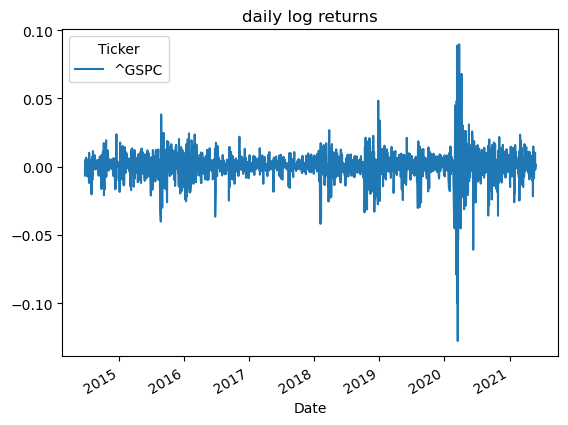

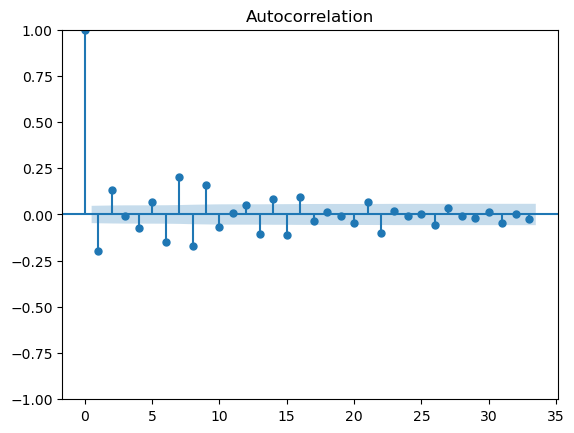

In [6]:
log_returns = np.log(stock_prices_t.Close/stock_prices_t.Close.shift(1)).dropna()
log_returns.plot()
plt.title('daily log returns')
plot_acf(log_returns)
plt.show()

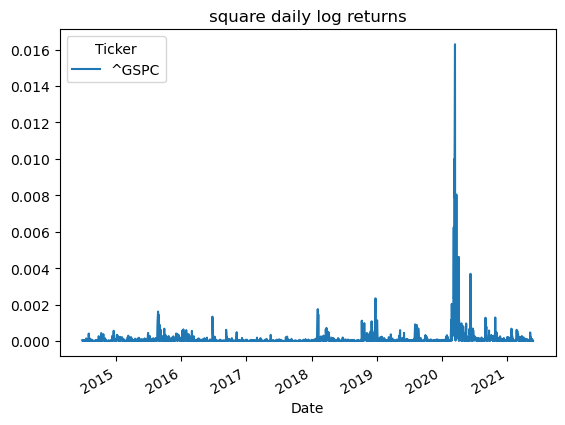

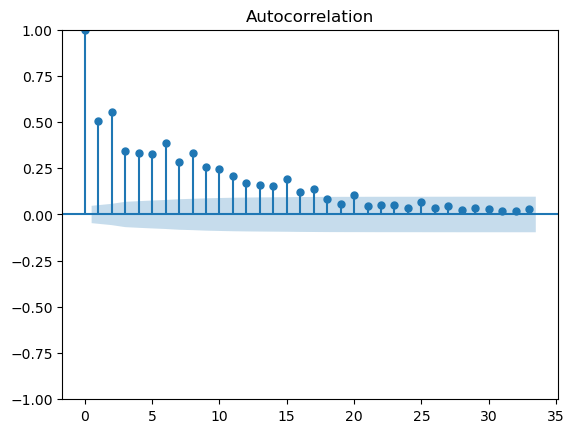

In [7]:
log_returns_sq = np.square(log_returns)
log_returns_sq.plot()
plt.title('square daily log returns')
plot_acf(log_returns_sq)
plt.show()

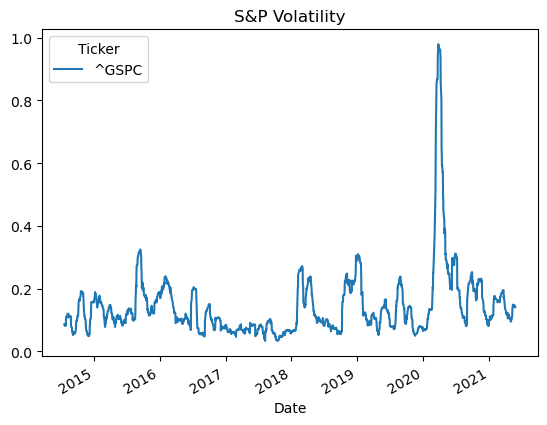

In [8]:
TRADING_DAYS = 20
volatility = log_returns.rolling(window=TRADING_DAYS).std()*np.sqrt(252)
volatility = volatility.dropna()
volatility.plot()
plt.title('S&P Volatility')
plt.show()

In [9]:
drift_X = log_returns.mean()*np.sqrt(252)

In [10]:
d = drift_X[0]

In [11]:
drift_X

Ticker
^GSPC    0.006926
dtype: float64

## Ornstein-Uhlenbeck

Ornstein-Uhlenbeck is a stochastic process that is a stationary Gauss-Markov process.

${\displaystyle dX_{t}=-\kappa \,X_{t}\,dt+\sigma \,dW_{t}}$

Sometimes, an additional drift term is sometimes added - this is known as the Vasicek model:

${\displaystyle dX_{t}=\kappa (\theta -X_{t})\,dt+\sigma \,dW_{t}}$

### Maximum Log-likelihood Estimation (MLE)

Probability Density Function of Normal Distribution is:

 $\Large f_\theta (x)=\frac{1}{\sqrt{2\pi \sigma^2}} e^{\frac{-(x-\mu)^2}{2 \sigma^2}}$


If we have random samples $y_i, i = 1,...,N$ from a density $f_\theta (y)$ indexed bu some parameter $\theta$.

Joint Probability Density Function or Likelihood function:
$ f(x_1,...x_n|\theta) =  f(x_1|\theta)...f(x_n|\theta) = \prod^n_{i=1}f(X_i|\theta) = L(\theta)$

The likelihood function is the density function regarded as a function of $\theta$.
$ L(\theta|x) = f(x|\theta), \theta \in \Theta$

The maximum likelihood estimator (MLE):

$\hat{\theta}(x) = arg \underset{\theta}{max} L(\theta|x)$

Log-probability of the observed sample is:

$l(\theta) = \sum^N_{i=1} log f_\theta (y_i)$

The principle of maximum likelihood assumes that the most reasonable values for $\theta$ are those for which the probability of the observed sample is
largest.

Essentially we are completing least squares for the additive error model $Y = f_\theta(X) + \epsilon$, with $\epsilon \sim N(0, \sigma^2)$, is equivalent to maximum likelihood using the conditional likelihood:

$f(Y|X, \theta) = N(log f_\theta (X), \sigma^2)$

If we take the likelihood function and derive the partial dericatives with respect the each respective parameter, make equal to zero, then we solve for MLE.

$L(\mu, \sigma^2 | \theta) = (\frac{1}{\sqrt{2\pi \sigma^2}} e^{\frac{-(x_1-\mu)^2}{2 \sigma^2}}) ... \frac{1}{\sqrt{2\pi \sigma^2}} e^{\frac{-(x_n-\mu)^2}{2 \sigma^2}} = \frac{1}{\sqrt{(2\pi \sigma^2)^n}} e^{-\frac{1}{2\sigma^2}\sum^n_{i=1}(x_i-\mu)^2}$

Log-likelihood function

$l(\mu, \sigma^2 | \theta) = ln L(\mu, \sigma^2 | \theta) = -\frac{n}{2}(ln2\pi+ln\sigma^2)-\frac{1}{2\sigma^2}\sum^n_{i=1}(x_i-\mu)^2$

Sometimes this is not differentiable but in the case of the normal distribution we can use Lagrange multiplier method to find maximisation parameters.

- $\frac{\delta}{\delta \mu}ln L(\mu, \sigma^2 | \theta) = 0 = \frac{1}{\sigma^2}\sum^n_{i=1}(x_i-\mu) = \frac{1}{\sigma^2}n(\overline{x} - \mu)$
- $\hat{\mu}(x) = \overline{x}$

This is a local maximum because the second partial derivative with respect to $\mu$ is negative, hence concave function.

- $\frac{\delta}{\delta \sigma^2}ln L(\mu, \sigma^2 | \theta) = 0 = -\frac{n}{2\sigma^2}+\frac{1}{2(\sigma^2)^2}\sum^n_{i=1}(x_i-\mu)^2 =  -\frac{n}{2(\sigma^2)^2}(\sigma^2+\frac{1}{n}\sum^n_{i=1}(x_i-\mu)^2)$
- $\hat{\sigma}^2(x)=\frac{1}{n}\sum^n_{i=1}(x_i-\overline{x})^2$

In [12]:
def MLE_norm(x):
    mu_hat = np.mean(x)
    sigma2_hat = np.var(x)
    return mu_hat, sigma2_hat

In [13]:
mu = 5
sigma = 2.5
N = 10000

np.random.seed(0)
x = np.random.normal(loc=mu, scale=sigma, size=(N,))

mu_hat, sigma2_hat = MLE_norm(x)

for_mu_hat = '$\hat{\mu} = '+format(round(mu_hat,2))+'$'
for_sigma2_hat = '$\hat{\sigma} = '+format(round(np.sqrt(sigma2_hat),2))+'$'

print('The MLE for data is:')
display(Latex(for_mu_hat))
display(Latex(for_sigma2_hat))

The MLE for data is:


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

### performing MLE numerically

If the log likelihood function wasn't continuous or differentiable. Can solve numerically through an optimisation problem where objective function is ...

The maximum likelihood estimator (MLE):
$\hat{\theta}(x) = arg$ $\underset{\theta}{max}$ $L(\theta|x)$

$\hat{\theta}(x) = arg$ $\underset{\theta}{max}$  $ln$ $L(\theta|x)$

$L(\theta) = \prod^n_{i=1}f(X_i|\theta)$

$ln f(X∣\theta)=\sum_{i=1}^N ln f(x_i∣\theta)$

In [14]:
def log_likelihood(theta, x):
    mu = theta[0]
    sigma = theta[1]

    l_theta = np.sum( np.log( sc.stats.norm.pdf(x, loc=mu, scale=sigma) ) )

    return -l_theta

def sigma_pos(theta):
    sigma = theta[1]
    return sigma

In [15]:
cons_set = {'type':'ineq', 'fun': sigma_pos}

theta0 = [2,3]
opt = sc.optimize.minimize(fun=log_likelihood, x0=theta0, args=(x,), constraints=cons_set)

for_mu_hat = '$\hat{\mu} = '+format(round(opt.x[0],2))+'$'
for_sigma2_hat = '$\hat{\sigma} = '+format(round(opt.x[1],2))+'$'

print('The MLE for data is:')
display(Latex(for_mu_hat))
display(Latex(for_sigma2_hat))

The MLE for data is:


C:\Users\PRASHANT\AppData\Local\Temp\ipykernel_28836\2834658178.py:5: RuntimeWarning: divide by zero encountered in log
  l_theta = np.sum( np.log( sc.stats.norm.pdf(x, loc=mu, scale=sigma) ) )


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

### So what's the distribution function of Ornstein-Uhlenbeck process?

Solution use, Ito Calculus to find equation for $d(X_t)$ and then determine Expectation and Variance of $X_t$.

Find dynamics of $X_t$

1. Rearrange

- ${\displaystyle dX_{t}=\kappa (\theta -X_{t})\,dt+\sigma \,dW_{t}}$
- $dX_t= \kappa \theta dt -\kappa X_t dt+\sigma dW_t$
- $dX_t + \kappa X_t dt = \kappa \theta dt + \sigma dW_t$

We recognise: $d(e^{\kappa t} X_t) =  e^{\kappa t}dX_t + \kappa e^{\kappa t} X_t dt$,

2. so multiply equation through by $e^{\kappa t}$ term. Take integral over time horizon $t \in [0,T]$

- $\int^T_0 d(e^{\kappa t} X_t) = \int^T_0 \kappa \theta e^{\kappa t} dt + \int^T_0 \sigma e^{\kappa t} dW_t$
- $ e^{\kappa T} X_T - X_0 = \kappa \theta \frac{e^{\kappa T}-1}{\kappa} + \sigma \int^T_0 e^{\kappa t} dW_t$
- $ X_T = X_0 e^{-\kappa T} + \theta (1 - e^{-\kappa T}) + \sigma \int^T_0 e^{-\kappa (T-t)} dW_t$



3. Expectation

- $E[X_T] = X_0 e^{-\kappa T} + \theta (1 - e^{-\kappa T})$

4. Variance
- $Var[X_T] = E[(\sigma \int^T_0 e^{-\kappa (T-t)} dW_t)^2]$


- $Var[X_T] = \frac{\sigma^2}{2 \kappa}(1-e^{-2\kappa T}) $

Now the stochastic process is normally distributed with $E[X_t]$ and $Var[X_t]$.
- $X_t \sim N(\mu, \sigma)$
- $X_t = \mu + \sigma  Z_t$ where $Z_t \sim N(0, 1)$

- $X_{t+\Delta t} = X_t e^{-\kappa T} + \theta (1 - e^{-\kappa T}) + \sigma \sqrt{\frac{(1-e^{-2\kappa T})}{2 \kappa}} N(0,1)$

### MLE of Ornstein-Uhlenbeck process
- $X_t \sim N(\mu, \overline{\sigma})$
- $E[X_{t+\delta t}] = X_t e^{-\kappa \delta t} + \theta (1 - e^{-\kappa \delta t})$
- $Var[X_{t+\delta t}] = \frac{\sigma^2}{2 \kappa}(1-e^{-2\kappa \delta t}) $

 $\Large f_\overline{\theta} (x_{t+\delta t} | x_t, \kappa, \theta, \sigma)=\frac{1}{\sqrt{2\pi \overline{\sigma}^2}} e^{\frac{-(x-\mu)^2}{2 \overline{\sigma}^2}}$
 - $\mu(x_t, \kappa, \theta) = x_t e^{-\kappa \delta t} + \theta (1 - e^{-\kappa \delta t})$
- $\overline{\sigma}(\kappa, \sigma) = \sigma \sqrt{\frac{(1-e^{-2\kappa \delta t})}{2 \kappa}}$

In [16]:
def mu(x, dt, kappa, theta):
    ekt = np.exp(-kappa*dt)
    return x*ekt + theta*(1-ekt)

def std(dt, kappa, sigma):
    e2kt = np.exp(-2*kappa*dt)
    return sigma*np.sqrt((1-e2kt)/(2*kappa))

In [17]:
def log_likelihood_OU(theta_hat, x):
    kappa = theta_hat[0]
    theta = theta_hat[1]
    sigma = theta_hat[2]

    x_dt = x[1:]
    x_t = x[:-1]

    dt = 1/252

    mu_OU = mu(x_t, dt, kappa, theta)
    sigma_OU = std(dt, kappa, sigma)

    l_theta_hat = np.sum( np.log( sc.stats.norm.pdf(x_dt, loc=mu_OU, scale=sigma_OU) ) )

    return -l_theta_hat

def kappa_pos(theta_hat):
    kappa = theta_hat[0]
    return kappa

def sigma_pos(theta_hat):
    sigma = theta_hat[2]
    return sigma

In [18]:
vol = np.array(volatility)

In [19]:
cons_set = [{'type':'ineq', 'fun': kappa_pos},
            {'type':'ineq', 'fun': sigma_pos}]

theta0 = [1,3,1]
opt = sc.optimize.minimize(fun=log_likelihood_OU, x0=theta0, args=(vol,), constraints=cons_set)

opt

C:\Users\PRASHANT\AppData\Local\Temp\ipykernel_28836\2647084026.py:14: RuntimeWarning: divide by zero encountered in log
  l_theta_hat = np.sum( np.log( sc.stats.norm.pdf(x_dt, loc=mu_OU, scale=sigma_OU) ) )


 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -5082.150625827537
       x: [ 1.620e+00  1.480e-01  2.028e-01]
     nit: 27
     jac: [ 1.221e-04 -1.318e-02 -3.894e-02]
    nfev: 125
    njev: 26

In [20]:
kappa = round(opt.x[0],3)
theta = round(opt.x[1],3)
sigma = round(opt.x[2],3)
vol0 = vol[-1]

for_kappa_hat = '$\hat{\kappa} = '+str(kappa)+'$'
for_theta_hat = '$\hat{\Theta} = '+str(theta)+'$'
for_sigma_hat = '$\hat{\sigma} = '+str(sigma)+'$'

print('The MLE for data is:')
display(Latex(for_kappa_hat))
display(Latex(for_theta_hat))
display(Latex(for_sigma_hat))
print('Last Volatility', np.round(vol0,3))

The MLE for data is:


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Last Volatility [0.141]


### Simulating Ornstein-Uhlenbeck process:

${\displaystyle dX_{t}=\kappa (\theta -X_{t})\,dt+\sigma \,dW_{t}}$

Continuous-time stochastic process:

$ X_t = X_0 e^{-\kappa t} + \theta (1 - e^{-\kappa t}) + \sigma \int^t_0 e^{-\kappa (t-s)} dW_s$

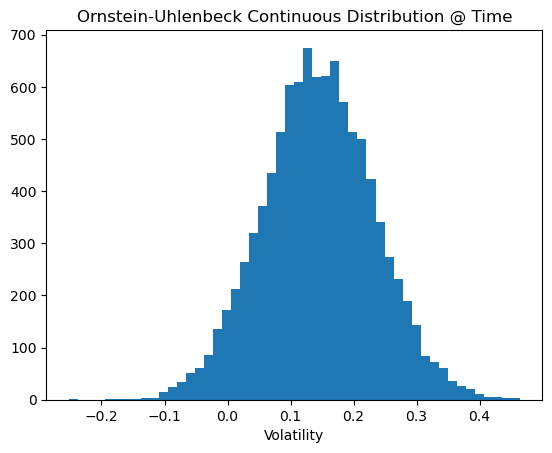

In [21]:
# define parameters
Time = 0.3
M = 10000

Z = np.random.normal(size=(M))

def mu(x, dt, kappa, theta):
    ekt = np.exp(-kappa*dt)
    return x*ekt + theta*(1-ekt)

def std(dt, kappa, sigma):
    e2kt = np.exp(-2*kappa*dt)
    return sigma*np.sqrt((1-e2kt)/(2*kappa))

drift_OU = mu(vol0, Time, kappa, theta)
diffusion_OU = std(Time, kappa, sigma)
vol_OU = drift_OU + diffusion_OU*Z

plt.hist(vol_OU, bins =50)
plt.title('Ornstein-Uhlenbeck Continuous Distribution @ Time')
plt.xlabel('Volatility')
plt.show()

### Discretised SDE

Euler-Maryuama discretisation: This is an approximation of variance...

$\Delta x_{t+1} = \kappa(\theta - x_t) \Delta t + \sigma \sqrt{\Delta t} \epsilon_t$

where parameters are assigned as from above optimisation

In [22]:
# Initialise Parameters for discretization
days = 1
years = 2

dt = days/252

M = 100
N = int(years/dt) 

### Python Loop

Execution time 0.009000062942504883


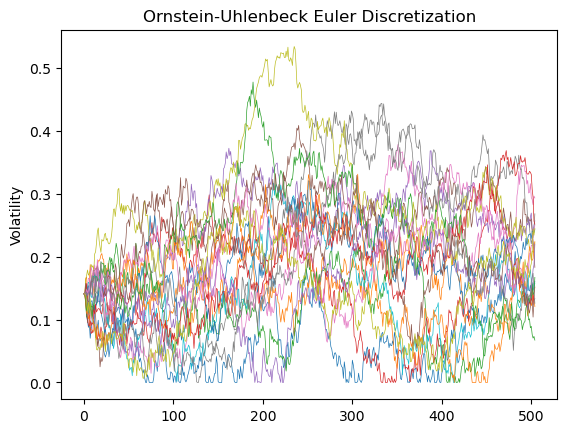

In [24]:
vol_OU = np.full(shape=(N, M), fill_value=vol0)
Z = np.random.normal(size=(N, M))

start_time = time.time()
for t in range(1,N):
    drift_OU = kappa*(theta - vol_OU[t-1])*dt
    diffusion_OU = sigma*np.sqrt(dt)
    vol_OU[t] = np.maximum(0, vol_OU[t-1] + drift_OU + diffusion_OU*Z[t])
print('Execution time', time.time() - start_time)

vol_OU = np.concatenate( (np.full(shape=(1, M), fill_value=vol0), vol_OU ) )
plt.plot(vol_OU[:,1:20], linewidth = 0.5)
plt.title('Ornstein-Uhlenbeck Euler Discretization')
plt.ylabel('Volatility')
plt.show()

# Stock Price Prediction with Geometric Brownian Motion


Stochastic differential equation (SDE)

${\displaystyle dS_{t} = \mu S_{t} \,dt + \sigma S_{t} \,dW_{t}}$



GBM stochastic process (solution) 

$S_{t} = S_{0} \exp \left( \left(\mu - \frac{\sigma^2}{2}\right)t + \sigma W_{t} \right)$

In [74]:
dates = pd.date_range(start="2021-06-01", periods=504, freq="B")
len(dates)

504

Not sure why recursive function is so slow in google colab - suspect that there is no benefit here of using RAM for in-memory storage vs actual computer compiling?? Comment in Discord channel if you know why?

In [83]:
S0 = stock_prices_t['Close'].iloc[-1]  # Use the last known price as initial

# Simulate stock price paths
stock_prices_simulated = np.zeros((N, M))
stock_prices_simulated[0] = S0  # Set initial price for all simulations

# Simulate future stock prices using the simulated volatility
for t in range(1, N):
    # The stock price follows a log-normal distribution with drift and volatility
    drift = d * dt  # Drift term (e.g., 5% return)
    diffusion = vol_OU[t-1] * np.sqrt(dt) * Z[t]  # Diffusion term based on volatility)
    stock_prices_simulated[t] = stock_prices_simulated[t-1] * np.exp(drift + diffusion


In [84]:
stock_prices_simulated.shape

(504, 100)

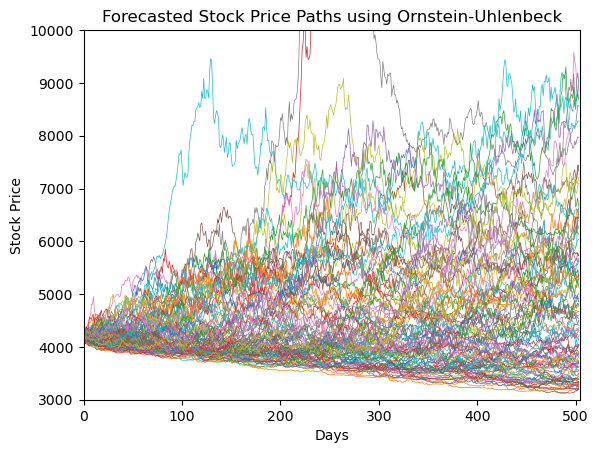

In [85]:
# Plot the forecasted stock price paths
plt.plot(stock_prices_simulated, linewidth =0.5)
plt.title("Forecasted Stock Price Paths using Ornstein-Uhlenbeck")
plt.xlabel("Days")
plt.xlim(0,504)
plt.ylabel("Stock Price")
plt.ylim(3000, 10000)
plt.show()

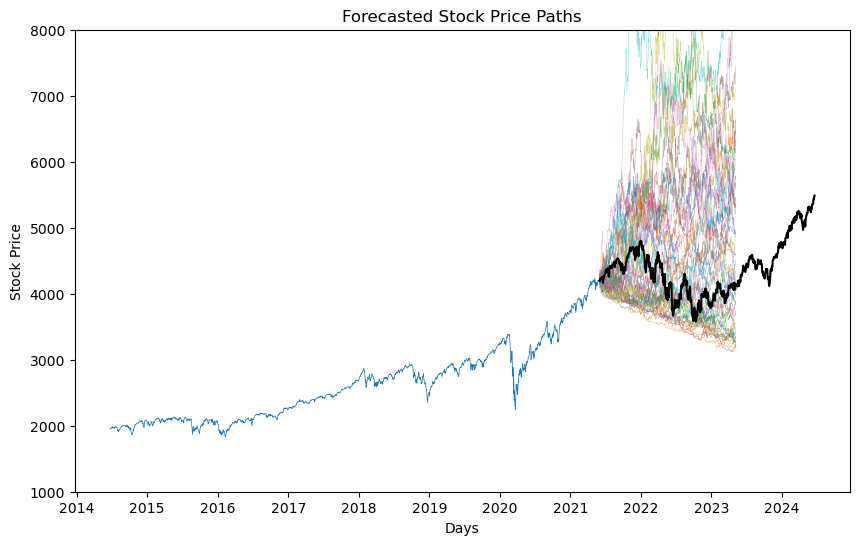

In [86]:
dates = pd.date_range(start="2021-06-01", periods=504, freq="B")

plt.figure(figsize=(10, 6))
for j in range(50):
    plt.plot(dates, stock_prices_simulated[:,j], alpha=0.6, linewidth=0.3)

plt.plot(stock_prices_t["Adj Close"], linewidth=0.5)
plt.plot(stock_prices_te["Adj Close"], linewidth=1.5, color = "Black" )

plt.title("Forecasted Stock Price Paths")
plt.xlabel("Days")
plt.ylabel("Stock Price")
plt.ylim(1000, 8000)
plt.show()

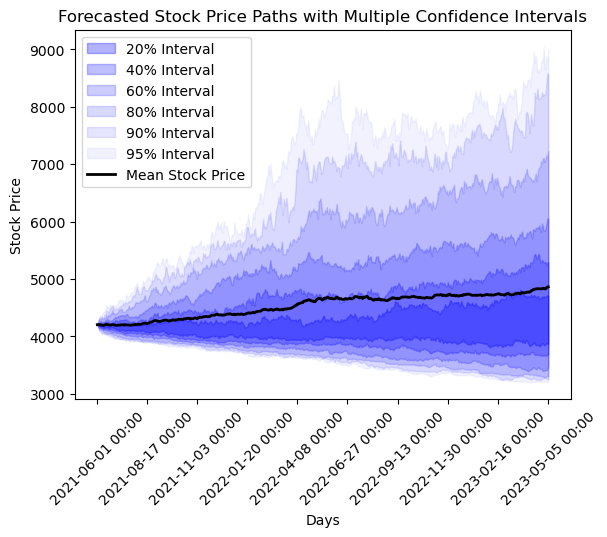

In [79]:
intervals = [20, 40, 60, 80, 90, 95]  # Confidence intervals to plot
base_color = "blue"  # Base color for all intervals
alpha_values = [0.3, 0.25, 0.2, 0.15, 0.1, 0.05]  # Increasing transparency for larger intervals

# Plot multiple confidence intervals
for i, interval in enumerate(intervals):
    lower_bound = np.percentile(stock_prices_simulated, (100 - interval) / 2, axis=1)
    upper_bound = np.percentile(stock_prices_simulated, 100 - (100 - interval) / 2, axis=1)
    plt.fill_between(range(stock_prices_simulated.shape[0]), lower_bound, upper_bound,
                     color=base_color, alpha=alpha_values[i], label=f"{interval}% Interval")

# Plot the mean stock price
mean_values = np.mean(stock_prices_simulated, axis=1)
plt.plot(mean_values, color="black", label="Mean Stock Price", linewidth=2)

# Add labels, title, and legend
plt.title("Forecasted Stock Price Paths with Multiple Confidence Intervals")
plt.xlabel("Days")
plt.xticks(
    ticks=np.linspace(0, len(dates) - 1, 10, dtype=int),  # Add ticks at equal intervals
    labels=pd.Series(dates).iloc[
        np.linspace(0, len(dates) - 1, 10, dtype=int)
    ].dt.strftime("%Y-%m-%d %H:%M"),  # Format ticks as datetime
    rotation=45
)
plt.ylabel("Stock Price")
plt.legend(loc="upper left")  # Move legend to the top-left corner
plt.show()

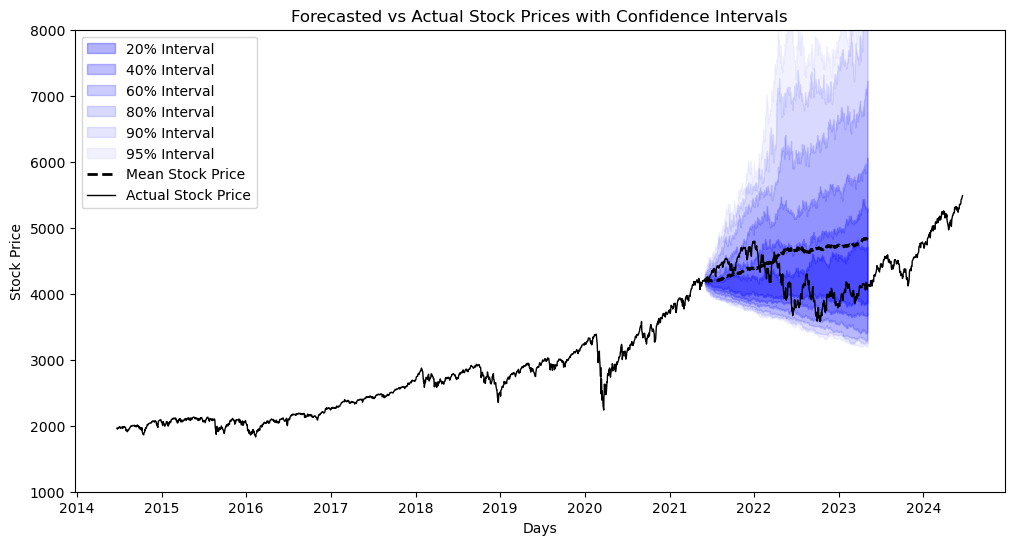

In [80]:
intervals = [20, 40, 60, 80, 90, 95]  # Confidence intervals to plot
base_color = "blue"  # Base color for all intervals
alpha_values = [0.3, 0.25, 0.2, 0.15, 0.1, 0.05]  # Increasing transparency for larger intervals

plt.figure(figsize=(12, 6))

# Plot confidence intervals for simulated data
for i, interval in enumerate(intervals):
    lower_bound = np.percentile(stock_prices_simulated, (100 - interval) / 2, axis=1)
    upper_bound = np.percentile(stock_prices_simulated, 100 - (100 - interval) / 2, axis=1)
    plt.fill_between(
        dates,  # X-axis range
        lower_bound,
        upper_bound,
        color=base_color,
        alpha=alpha_values[i],
        label=f"{interval}% Interval"
    )

# Plot the mean stock price
mean_values = np.mean(stock_prices_simulated, axis=1)
plt.plot(dates,mean_values, color="black", label="Mean Stock Price",linestyle = "--", linewidth=2)

# Plot actual stock prices
plt.plot(stock_prices["Close"], color="black", label="Actual Stock Price", linewidth=1)

# Add labels, title, and legend
plt.title("Forecasted vs Actual Stock Prices with Confidence Intervals")
plt.xlabel("Days")
plt.ylabel("Stock Price")
plt.legend(loc="upper left")
plt.ylim(1000,8000)

# Format x-axis with datetime ticks

# Display the plot
plt.show()

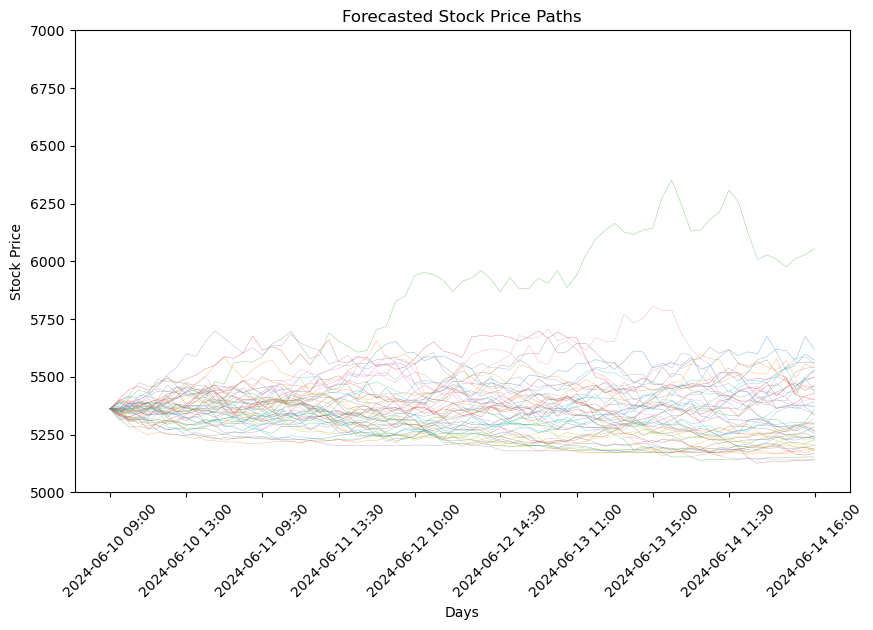

In [82]:
plt.figure(figsize=(10, 6))
for j in range(50):
  plt.plot(date_index, stock_prices_d[:, j], alpha=0.6, linewidth=0.3)
  plt.xticks(
    ticks=np.linspace(0, len(date_index) - 1, 10, dtype=int),  # Add ticks at equal intervals
    labels=pd.Series(date_range).iloc[
        np.linspace(0, len(date_range) - 1, 10, dtype=int)
    ].dt.strftime("%Y-%m-%d %H:%M"),  # Format ticks as datetime
    rotation=45
)


plt.title("Forecasted Stock Price Paths")
plt.xlabel("Days")
plt.ylabel("Stock Price")
plt.ylim(5000, 7000)
plt.show()

In [ ]:
intervals = [20, 40, 60, 80, 90, 95]  # Confidence intervals to plot
base_color = "blue"  # Base color for all intervals
alpha_values = [0.3, 0.25, 0.2, 0.15, 0.1, 0.05]  # Increasing transparency for larger intervals

# Plot multiple confidence intervals
for i, interval in enumerate(intervals):
    lower_bound = np.percentile(stock_prices_simulated, (100 - interval) / 2, axis=1)
    upper_bound = np.percentile(stock_prices_simulated, 100 - (100 - interval) / 2, axis=1)
    plt.fill_between(range(stock_prices_simulated.shape[0]), lower_bound, upper_bound,
                     color=base_color, alpha=alpha_values[i], label=f"{interval}% Interval")

# Plot the mean stock price
mean_values = np.mean(stock_prices_simulated, axis=1)
plt.plot(mean_values, color="black", label="Mean Stock Price", linewidth=2)

# Add labels, title, and legend
plt.title("Forecasted Stock Price Paths with Multiple Confidence Intervals")
plt.xlabel("Days")
plt.xticks(
    ticks=np.linspace(0, len(dates) - 1, 10, dtype=int),  # Add ticks at equal intervals
    labels=pd.Series(dates).iloc[
        np.linspace(0, len(dates) - 1, 10, dtype=int)
    ].dt.strftime("%Y-%m-%d %H:%M"),  # Format ticks as datetime
    rotation=45
)
plt.ylabel("Stock Price")
plt.legend(loc="upper left")  # Move legend to the top-left corner
plt.show()